## Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from matplotlib.lines import Line2D

## Read and process dataset

In [2]:
df = pd.read_csv('thesis_dataset.csv')

In [3]:
# Dictionaries

# Classifying the types of satellite mechanisms (by hand)
mechanism_dict = {
    'All SAR': ['s1', 'sentinel-1', 'alos', 'terrasar-x', 'tandem-x', 'smrt', 'smtr', 'srtm', 'radarsat', 'saocom',' gaofen3', 'gf3'],
    'Optical': ['s2', 'sentinel-2', 'landsat', 'modis', 'worldview', 'quickbird', 'gaofen', 'gaofen1', 'gf1', 'gaofen2', 
                  'gf2', 'gaofen6', 'gf6', 'spot', 'spot-6', 'geoeye', 'eo', 'eo-1', 'pléiades neo', 'glass', 'rapideye', 
                  'alos-avnir', 'planet', 'hj'],
    'LiDAR': ['airborne', 'icesat', 'gedi', 'zy3', 'lidar', 'glas'],
    'Other': ['smos']
}

# Classifying the types of SAR satellite mechanisms (by hand)
sar_dict = {
    'X-band SAR': ['smrt', 'smtr', 'srtm', 'terrasar-x', 'tandem-x',],
    'C-band SAR': ['s1', 'sentinel-1', 'radarsat', 'gaofen3', 'gf3'],
    'L-band SAR': ['saocom', 'alos']
}

# convert all metrics to mg/ha
convert_to_mgha = {
    '': 1,
    'mg/ha': 1,
    't/ha': 1,
    'kg/m2': 10,
    'kg/ha':1/1000,
    't/acre': 2.47105,
    'g/m2': 0.01,
    'm3/hm2': 1,
    'm3/ha': 1,
    'mg/hm2': 1
}

custom_palette = [
    "#2C5F2D",  # deep forest green
    "#8FBC8F",  # sage green (more vibrant, still earthy)
    "#4682B4",  # steel blue (cooler than sky blue, more defined)
    "#7C4F20"  # burnt sienna / dry soil
]

better_var_names_dict = {
    'bpv': 'BPV',
    'canopy': 'Canopy', 
    'climate': 'Climate',
    'topo': 'Topography', 
    'bands': 'Raw Bands', 
    'vi': 'VI', 
    'texture': 'Texture', 
    'polar': 'Polarizations', 
    'backscatter': 'Backscatter',
    'soil': 'Soil'
}

In [4]:
def one_hot_encode(og_df, column, keys):
    for sat_mech in keys:
        encoder=[]
        for row in og_df[column]:
            if type(row)!=str: #for the nans
                encoder.append(0)
            elif sat_mech in row.split(','):
                encoder.append(1)
            else:
                encoder.append(0)
        og_df[sat_mech] = encoder

    return og_df

In [5]:
def build_classified_column(class_dict, class_column):
    new_column = []
    not_cat = []
    for item in df[class_column]:
        temp_data = []
        data = item.split(',')

        for d in data:
            d = d.lower().strip()
            checker=0
            for key, values in class_dict.items():
                if d in values and key not in temp_data:
                    temp_data.append(key)
                elif d not in values:
                    checker+=1
            if checker == 4:
                not_cat.append(d)

        new_column.append(','.join(temp_data))
    
    return new_column, not_cat

In [6]:
def convert_var_names(var_string):
    return ','.join(better_var_names_dict.get(var.strip(), var.strip()) for var in var_string.split(','))

In [7]:
# convert evaluation values from strings to floats
df.astype({'value': 'float32'});

# convert years to strings
df.astype({'year': 'int'});
df.astype({'year': 'str'});

In [8]:
# Building the one hot encoding for the satellite data analysis

#building a new column based on the classifications
mechanism_column, not_cat = build_classified_column(mechanism_dict, 'data')
df['data_mech'] = mechanism_column

# one hot encode the classifications
df = one_hot_encode(df, 'data_mech', mechanism_dict.keys())

#check if any satellites were missing in the classification
print('The satellites not classified are:')
print(set(not_cat))

The satellites not classified are:
set()


In [9]:
# Building the one hot encoding for the SAR satellite data analysis

#building a new column based on the classifications
sar_column, not_cat = build_classified_column(sar_dict, 'data')
df['data_sar'] = sar_column

# one hot encode the classifications
df = one_hot_encode(df, 'data_sar', sar_dict.keys())

In [10]:
# Building the one hot encoding for the variable analysis

# Apply name conversion
df['variables'] = df['variables'].apply(convert_var_names)

# create the list of unique variables
unique_vars = []
no_nan_vars = df['variables'].dropna()
for var_str in no_nan_vars.unique():
    vars = var_str.split(',')
    for var in vars:
        if var not in unique_vars:
            unique_vars.append(var)

# one hot encode them
df = one_hot_encode(df, 'variables', unique_vars)

In [11]:
# convert all units to mg/ha
value_col = []
unit_col = []

for i in range(len(df)):
    if isinstance(df.iloc[i]['unit'], str):
        value_col.append(convert_to_mgha[df.iloc[i]['unit']]*df.iloc[i]['value'])
        unit_col.append('mg/ha')
    else:
        value_col.append(df.iloc[i]['value'])
        unit_col.append(df.iloc[i]['unit'])

# adjust the columns with the new values

df = df.assign(unit=unit_col)
df = df.assign(value=value_col)

In [12]:
# Chack the max of the rmse values
metric_and_values = df[['metric', 'value', 'title']]
concern = max(metric_and_values[metric_and_values['metric'] == 'rmse']['value'])
print(metric_and_values[metric_and_values['value'] == concern])

# Chack the min of the rmse values
metric_and_values = df[['metric', 'value', 'title']]
concern = min(metric_and_values[metric_and_values['metric'] == 'rmse']['value'])
print(metric_and_values[metric_and_values['value'] == concern])

    metric     value                                              title
143   rmse  163.8238  Satellite-Based Carbon Estimation in Scotland:...
    metric  value                                              title
769   rmse  0.466  The Utility of Sentinel-2 Spectral Data in Qua...


## Evaluate ML Methods

In [13]:
def build_metric_dict(og_df, evaluation, metric, threshold):
    #select only the category of interest and metrics of interest
    metric_and_values = og_df[['metric', evaluation, 'value']]
    values_df = metric_and_values[metric_and_values['metric'] == metric]

    #make a list of variables of interest
    unique_methods = values_df[evaluation].unique()

    #initialize the dictionary for all together
    keys = 'All Methods'+' (n='+str(len(values_df['value']))+')'
    my_dict = {keys: values_df['value'].values}

    #build dict for all other methods
    other_list = []
    for method in unique_methods:
        temp_list = values_df[values_df[evaluation] == method]
        #only take frequently used methods
        if len(temp_list)>=threshold:
            key = method+' (n='+str(len(temp_list))+')'
            my_dict.update({key: temp_list['value'].values})
        else:
           other_list += list(temp_list['value'].values)
    other_key = 'other (n='+str(len(other_list))+')'
    my_dict.update({other_key: other_list})

    return my_dict

In [31]:
def plot_metrics(r2,rmse,method,colors,title):
    #initialize figure
    fig, ax = plt.subplots(1,2, figsize=(16,5))

    legend_elements = [
        Line2D([0], [0], color='black', lw=2, label='Mean'),
        Line2D([0], [0], color='white', lw=2, label='Median')
    ]

    if method=='boxplot':
        ax[0].boxplot(r2.values())
        ax[0].set_xticklabels(r2.keys(), rotation=-35)

        ax[1].boxplot(rmse.values())
        ax[1].set_xticklabels(rmse.keys(), rotation=-35)
    elif method=='violin':
        parts = ax[0].violinplot(r2.values(), showmedians=True, showmeans=True)
        ax[0].set_xticks(np.arange(len(r2.keys()))+1)
        ax[0].set_xticklabels(r2.keys(), rotation=-60)

        a = ax[0].legend(handles=legend_elements, loc='lower right')
        a.get_frame().set_facecolor('#a9a9a9') 

        i=0
        for pc in parts['bodies']:
            pc.set_facecolor(colors[i])
            pc.set_edgecolor(colors[i])
            pc.set_alpha(0.4)
            i+=1
        parts['cbars'].set_colors(colors)
        parts['cmins'].set_colors(colors)
        parts['cmaxes'].set_colors(colors)
        parts['cmeans'].set_edgecolor('black')
        parts['cmedians'].set_colors('white')


        parts = ax[1].violinplot(rmse.values(), showmedians=True, showmeans=True)
        ax[1].set_xticks(np.arange(len(rmse.keys()))+1)
        ax[1].set_xticklabels(rmse.keys(), rotation=-60)

        a = ax[1].legend(handles=legend_elements, loc='upper right')
        a.get_frame().set_facecolor('#a9a9a9')

        i=0
        for pc in parts['bodies']:
            pc.set_facecolor(colors[i])
            pc.set_edgecolor(colors[i])
            pc.set_alpha(0.4)
            i+=1
        parts['cbars'].set_colors(colors)
        parts['cmins'].set_colors(colors)
        parts['cmaxes'].set_colors(colors)
        parts['cmeans'].set_edgecolor('black')
        parts['cmedians'].set_colors('white')

    #plot r^2 metric
    ax[0].set_ylim(-0.05,1.05)
    ax[0].set_ylabel('$R^2$')
    ax[0].set_title("$R^2$ Distribution per %s"%title);

    #plt rmse metric
    ax[1].set_ylabel('$RMSE$ ($mg/ha$)')
    ax[1].set_title("$RMSE$ Distribution per %s"%title);

    plt.show()

In [15]:
def plot_wordcloud(topic):
    r2_df = df[df['metric'] == 'r^2']
    all_vars = ''
    for i in range(len(r2_df)):
        all_vars += df[topic][i] + ' and '

    all_vars = all_vars.replace(',', ' and ')

    #create and generate a word cloud image
    wordcloud = WordCloud(stopwords=['and'], background_color='white').generate(all_vars)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

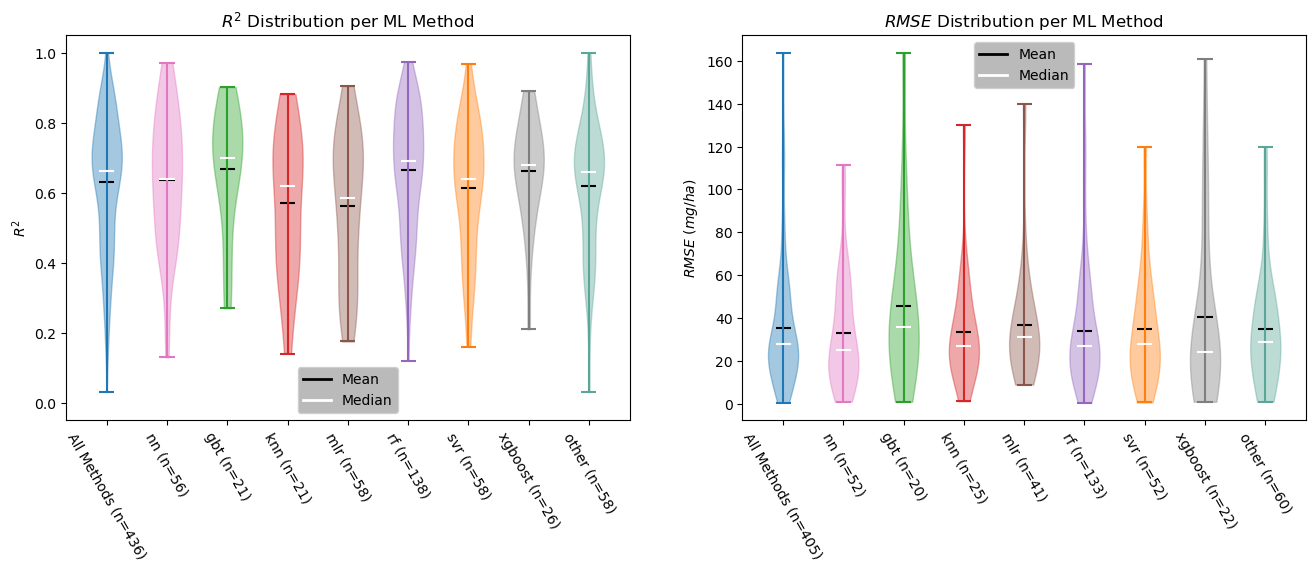

In [16]:
custom_palette_methods = [
    "#1F77B4",  # Blue - all
    "#E377C2",  # Pink - nn
    "#2CA02C",  # Green - gbt
    "#D62728",  # Red - knn
    "#8C564B",  # Brown - mlr
    "#9467BD",  # Purple - rf
    "#FF7F0E",  # Orange - svr
    "#7F7F7F",  # Gray - xgboost
    "#5BA698"   # deep cyan - other
]

ml_r2_dict = build_metric_dict(df, "method", "r^2", 20)
ml_rmse_dict = build_metric_dict(df, "method", "rmse", 20)

plot_metrics(ml_r2_dict, ml_rmse_dict, 'violin', custom_palette_methods, 'ML Method')

## Evaluate satelittes used

In [19]:
def build_encoded_dict(metric, unique_vars):
    metric_dict = {}

    metric_df = df[df['metric'] == metric]

    for var in unique_vars:
        temp_df = metric_df[metric_df[var] == 1]
        key = var+' (n='+str(len(temp_df))+')'
        metric_dict.update({key: temp_df['value'].values})

    return metric_dict

X-band SAR (n=100) 
 R^2 mean: 0.600194 
 R^2 median 0.635000 

C-band SAR (n=127) 
 R^2 mean: 0.639350 
 R^2 median 0.670000 

L-band SAR (n=74) 
 R^2 mean: 0.619681 
 R^2 median 0.640000 

All SAR (n=245) 
 R^2 mean: 0.611720 
 R^2 median 0.652000 

Optical (n=385) 
 R^2 mean: 0.636470 
 R^2 median 0.670000 

LiDAR (n=84) 
 R^2 mean: 0.623220 
 R^2 median 0.670000 

Other (n=10) 
 R^2 mean: 0.734790 
 R^2 median 0.720000 

X-band SAR (n=93) 
 RMSE mean: 38.240387 
 RMSE median 31.400000 

C-band SAR (n=120) 
 RMSE mean: 35.701711 
 RMSE median 24.930000 

L-band SAR (n=77) 
 RMSE mean: 36.888023 
 RMSE median 30.300000 

All SAR (n=233) 
 RMSE mean: 38.184083 
 RMSE median 29.820000 

Optical (n=360) 
 RMSE mean: 34.078013 
 RMSE median 27.295000 

LiDAR (n=80) 
 RMSE mean: 41.436550 
 RMSE median 32.065000 

Other (n=10) 
 RMSE mean: 28.733030 
 RMSE median 26.700000 



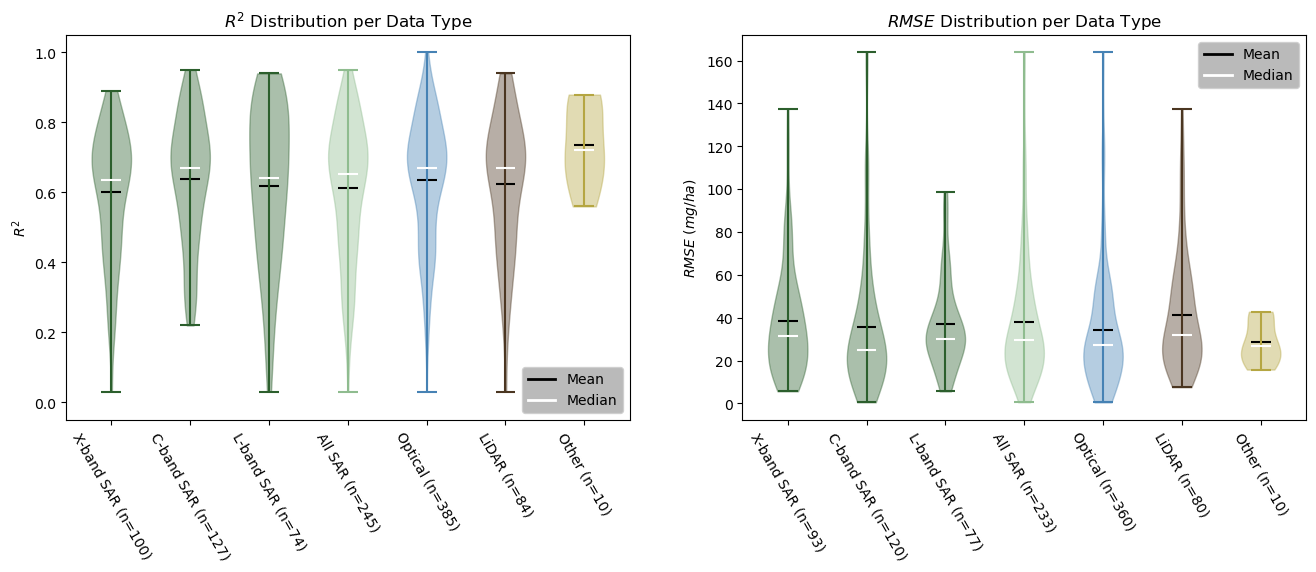

In [32]:
# Colors used in the plots 
custom_palette_data = [
    "#2C5F2D",  # deep forest green
    "#2C5F2D",  # deep forest green
    "#2C5F2D",  # deep forest green
    "#8FBC8F",  # sage green (more vibrant, still earthy)
    "#4682B4",  # steel blue (cooler than sky blue, more defined)
    "#4B3621",  # dark brown (carbon/peat)
    "#B5A642"  # burnt sienna / dry soil
]

sar_dict.update(mechanism_dict)
sat_r2_dict = build_encoded_dict('r^2', sar_dict.keys())
sat_rmse_dict = build_encoded_dict('rmse', sar_dict.keys())

for key in list(sat_r2_dict.keys()):
    mean_r2 = np.mean(sat_r2_dict[key])
    median_r2 = np.median(sat_r2_dict[key])
    print('%s \n R^2 mean: %f \n R^2 median %f \n'%(key,mean_r2,median_r2))

for key in list(sat_rmse_dict.keys()):
    mean_rmse = np.mean(sat_rmse_dict[key])
    median_rmse = np.median(sat_rmse_dict[key])
    print('%s \n RMSE mean: %f \n RMSE median %f \n'%(key,mean_rmse,median_rmse))

plot_metrics(sat_r2_dict, sat_rmse_dict, 'violin', custom_palette_data, 'Data Type')

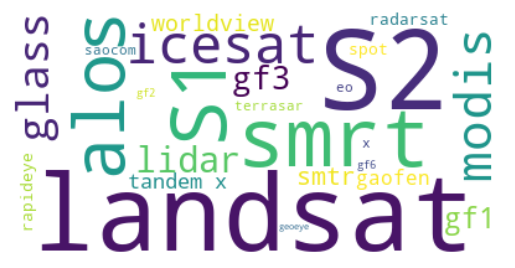

In [19]:
plot_wordcloud('data') #maybe include something similar

## Evaluate independent variables

VI (n=351) 
 R^2 mean: 0.627825 
 R^2 median 0.660000 

Topography (n=170) 
 R^2 mean: 0.623958 
 R^2 median 0.665000 

Climate (n=91) 
 R^2 mean: 0.584241 
 R^2 median 0.620000 

Raw Bands (n=298) 
 R^2 mean: 0.643436 
 R^2 median 0.671500 

Texture (n=188) 
 R^2 mean: 0.631922 
 R^2 median 0.666500 

BPV (n=67) 
 R^2 mean: 0.611322 
 R^2 median 0.660000 

Backscatter (n=105) 
 R^2 mean: 0.592136 
 R^2 median 0.622000 

Polarizations (n=97) 
 R^2 mean: 0.599432 
 R^2 median 0.630000 

Canopy (n=99) 
 R^2 mean: 0.652349 
 R^2 median 0.690000 

Soil (n=12) 
 R^2 mean: 0.663108 
 R^2 median 0.685000 

VI (n=327) 
 RMSE mean: 33.500290 
 RMSE median 26.000000 

Topography (n=163) 
 RMSE mean: 39.743780 
 RMSE median 30.300000 

Climate (n=91) 
 RMSE mean: 31.583478 
 RMSE median 29.630000 

Raw Bands (n=278) 
 RMSE mean: 35.750147 
 RMSE median 27.650000 

Texture (n=169) 
 RMSE mean: 35.221409 
 RMSE median 26.431500 

BPV (n=65) 
 RMSE mean: 50.283892 
 RMSE median 47.190000 

Backscatt

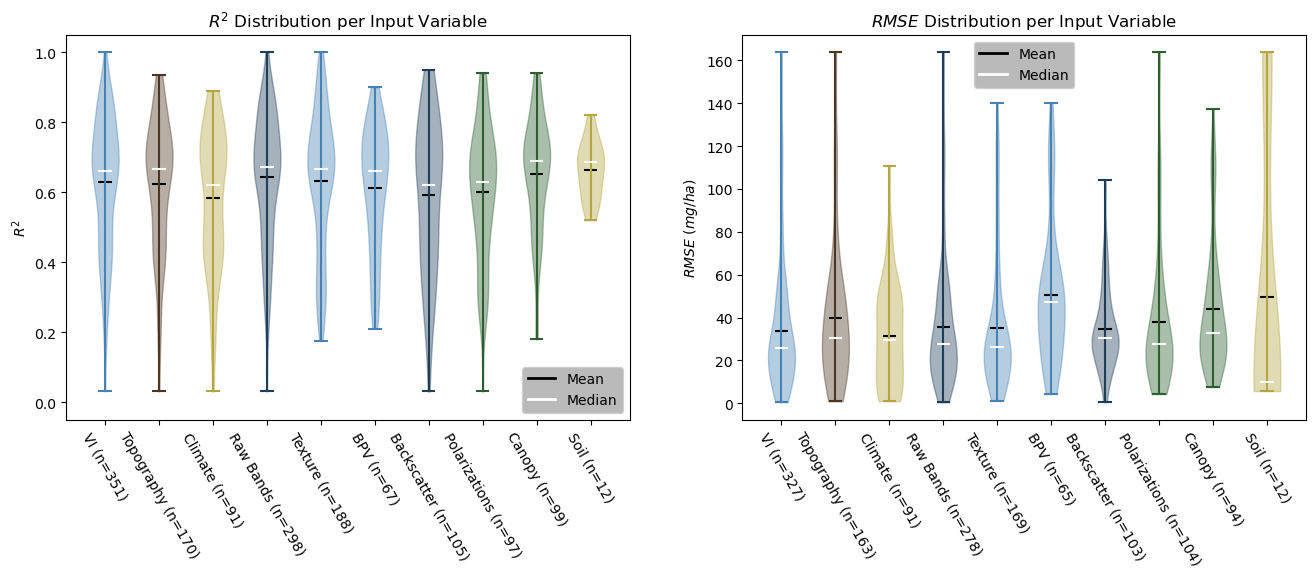

In [28]:
custom_palette_vars = [
    "#4682B4",  # steel blue (cooler than sky blue, more defined)
    "#4B3621",  # dark brown (carbon/peat)  
    "#B5A642",  # burnt sienna / dry soil
    "#1E3D59",  # deep navy for lake/deep water
    "#4682B4",  # steel blue (cooler than sky blue, more defined)
    "#4682B4",  # steel blue (cooler than sky blue, more defined)
    "#1E3D59",  # deep navy for lake/deep water
    "#2C5F2D",  # deep forest green
    "#2C5F2D",  # deep forest green
    "#B5A642"  # burnt sienna / dry soil
]

vars_r2_dict = build_encoded_dict('r^2', unique_vars)
vars_rmse_dict = build_encoded_dict('rmse', unique_vars)

for key in list(vars_r2_dict.keys()):
    mean_r2 = np.mean(vars_r2_dict[key])
    median_r2 = np.median(vars_r2_dict[key])
    print('%s \n R^2 mean: %f \n R^2 median %f \n'%(key,mean_r2,median_r2))

for key in list(vars_rmse_dict.keys()):
    mean_rmse = np.mean(vars_rmse_dict[key])
    median_rmse = np.median(vars_rmse_dict[key])
    print('%s \n RMSE mean: %f \n RMSE median %f \n'%(key,mean_rmse,median_rmse))

plot_metrics(vars_r2_dict, vars_rmse_dict,'violin',custom_palette_vars,'Input Variable') 

## Year analysis

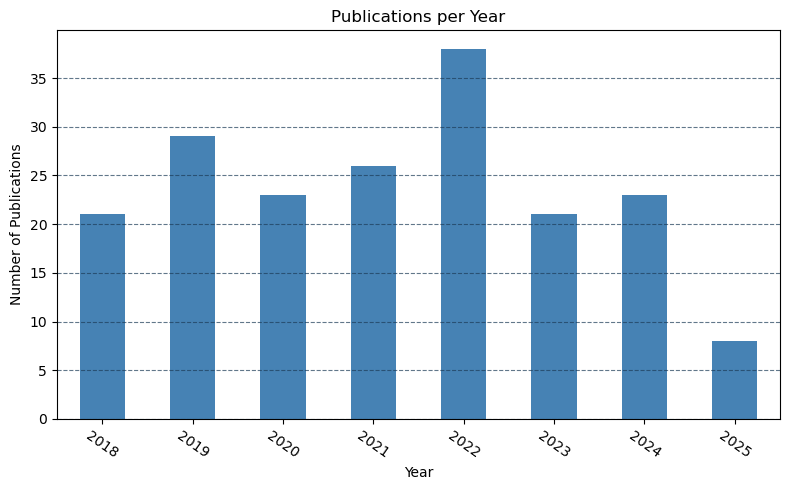

In [21]:
year_analysis =  df[['year', 'title']].drop_duplicates(['year', 'title'])

counts = year_analysis['year'].value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 5))
counts.plot(kind='bar', color="#4682B4")

plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.title('Publications per Year')
plt.grid(axis='y', linestyle='--', alpha=0.7, color="#1E3D59")
plt.xticks(rotation=-35)

plt.tight_layout()
plt.show()

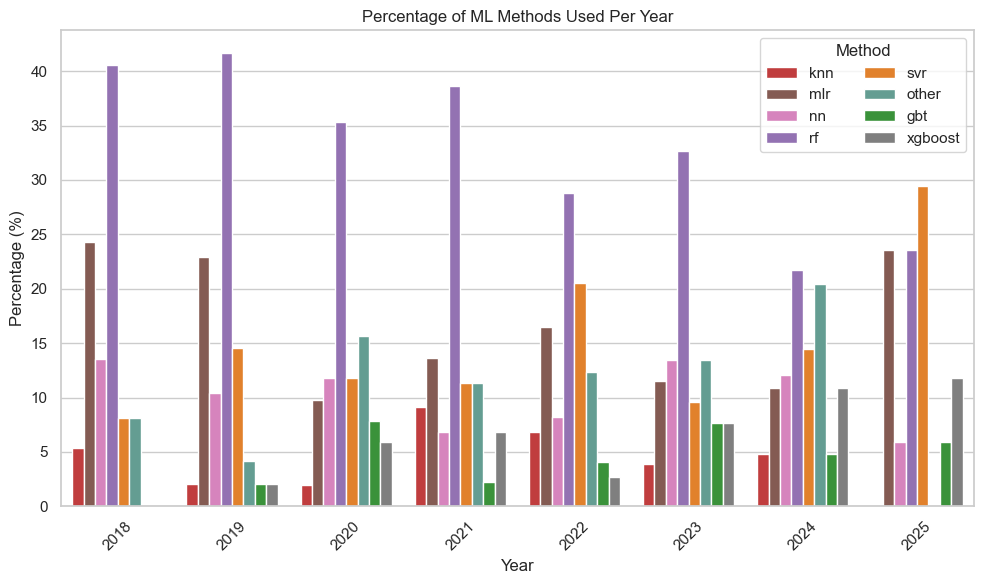

In [22]:
# Plot change of ml method overtime

# Figure out which methods to include (n>15)
common_methods = []
for method in list(ml_r2_dict.keys()):
    name = method.split()[0]
    common_methods.append(name)

all_methods = df['method'].unique()
other_methods = [m for m in all_methods if m.split()[0] not in common_methods]

# Count the frequency of each method per year
data = df[df['method'].isin(common_methods)][['method', 'year', 'title']].drop_duplicates()
method_counts = data.groupby(['method', 'year']).size().reset_index(name='count')

other_data = df[df['method'].isin(other_methods)][['method', 'year', 'title']].drop_duplicates()
other_counts = other_data.groupby('year').size().reset_index(name='count')
other_counts['method'] = 'other'  # Label all as 'Other'
other_counts = other_counts[['method', 'year', 'count']]

full_counts = pd.concat([method_counts, other_counts], ignore_index=True)

# Calculate total per year and compute percentage
totals = full_counts.groupby('year')['count'].transform('sum')
full_counts['percentage'] = full_counts['count'] / totals * 100

# Plotting
custom_palette_methods = [
    "#D62728",  # Red - knn
    "#8C564B",  # Brown - mlr
    "#E377C2",  # Pink - nn
    "#9467BD",  # Purple - rf
    "#FF7F0E",  # Orange - svr
    "#5BA698",  # deep cyan - other
    "#2CA02C",  # Green - gbt
    "#7F7F7F",   # Gray - xgboost
]

# Plot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.barplot(
    data=full_counts,
    x='year',
    y='percentage',
    hue='method',
    palette=custom_palette_methods
)

plt.title('Percentage of ML Methods Used Per Year')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.legend(title='Method', loc='upper right', ncol=2)
plt.tight_layout()
plt.show()

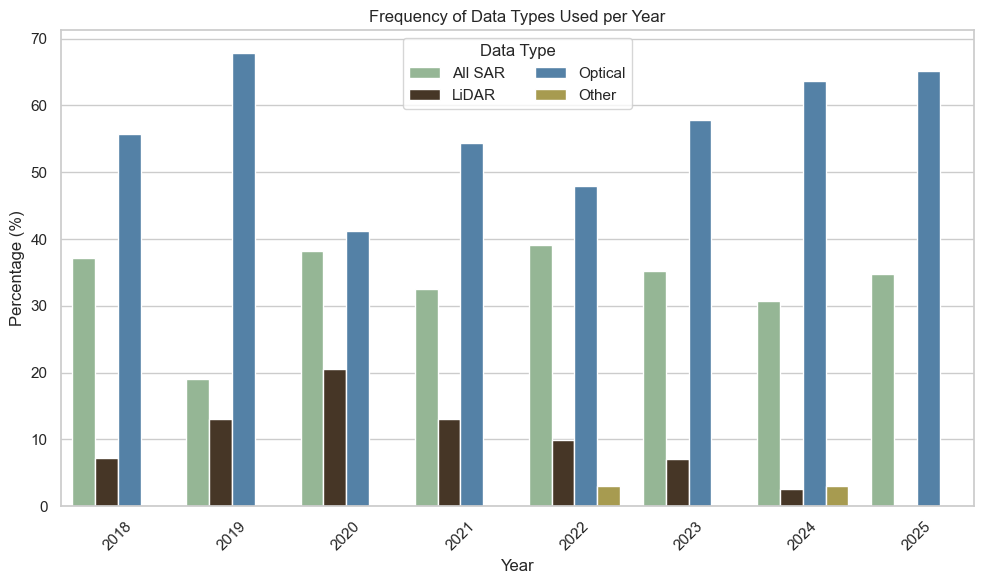

In [34]:
# Plot change of data over time
custom_palette_year_data = [
    "#8FBC8F",  # deep forest green
    "#4B3621",  # dark brown (carbon/peat)
    "#4682B4",  # steel blue (cooler than sky blue, more defined)
    "#B5A642"  # burnt sienna / dry soil
]

melted = df.melt(id_vars=['year', 'title'],
                   value_vars=['All SAR', 'Optical', 'LiDAR', 'Other'],
                   var_name='SensorType',
                   value_name='Used')

# Filter rows where sensor was used (value = 1)
used_sensors = melted[melted['Used'] == 1]

# Count occurrences per Year and SensorType
counts = used_sensors.groupby(['year', 'SensorType']).size().reset_index(name='count')

# Calculate percentages per year
counts['percentage'] = counts.groupby('year')['count'].transform(lambda x: x / x.sum() * 100)

# Plotting
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.barplot(
    data=counts, 
    x='year', 
    y='percentage', 
    hue='SensorType', 
    palette=custom_palette_year_data
)

plt.title('Frequency of Data Types Used per Year')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.legend(title='Data Type', loc='upper center', ncol=2)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()